# Implementation of UNIT for SVHN <−−> MNIST transfer
Implementation of [Unsupervised Image-to-Image Translation Networks](https://arxiv.org/pdf/1703.00848.pdf) for transforming the SVHN domain to the MNIST one, using Tensorflow.

**References** :

[1] UNIT: https://arxiv.org/pdf/1703.00848.pdf

[2] Instance normalization: https://arxiv.org/abs/1607.08022

[3] Wasserstein GAN: https://arxiv.org/abs/1701.07875

In [82]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
from skimage import color, transform
import time
import os
import shutil
from tqdm import tqdm, tqdm_notebook

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

from torchvision import datasets

from IPython.display import clear_output

## Parameters

In [ ]:
batch_size = 64

folder_mnist = "/home/arthur/datasets/mnist"
folder_svhn = "/home/arthur/datasets/svhn"
download_svhn = False # mnist is automatically downloaded if not in the folder

colormap = np.array(plt.rcParams['axes.prop_cycle'].by_key()['color'])

dropout_keep_prob = 0.5

## Create the datasets

In [106]:
def normalize(x, max_value):
    """ If x takes its values between 0 and max_value, normalize it between -1 and 1"""
    return (x / float(max_value)) * 2 - 1

### SVHN

We follow the methodology of [1] and use the "extra" SVHN set as the training set. The test set can be useful for evaluations beyond the paper.

Concerning the transformation, we turn the 32x32 RGB images to grayscale and normalize them between -1 and 1

In [ ]:
svhn_train = datasets.SVHN(root=folder_svhn, download=download_svhn, split="extra")
svhn_test = datasets.SVHN(root=folder_svhn, download=download_svhn, split="test")

In [ ]:
def transform_svhn(X):
    X = np.transpose(X, (0,2,3,1))
    X = normalize(X, 256)
    X = X.reshape(len(X), 32, 32, 3)
    
    return X

In [ ]:
print("Transforming SVHN train...")
X_svhn_train = transform_svhn(svhn_train.data)

print("Transforming SVHN test...")
X_svhn_test = transform_svhn(svhn_test.data)

In [ ]:
lb_svhn = LabelBinarizer()

Y_svhn_train = lb_svhn.fit_transform(svhn_train.labels.flatten() % 10)
Y_svhn_test = svhn_test.labels.flatten() % 10

### MNIST

Resize 28x28 grayscale images to 32x32 grayscale images

In [83]:
mnist = input_data.read_data_sets(folder_mnist, one_hot=False)

Extracting /home/arthur/datasets/mnist/train-images-idx3-ubyte.gz
Extracting /home/arthur/datasets/mnist/train-labels-idx1-ubyte.gz
Extracting /home/arthur/datasets/mnist/t10k-images-idx3-ubyte.gz
Extracting /home/arthur/datasets/mnist/t10k-labels-idx1-ubyte.gz


In [107]:
def transform_mnist(X, use_inverse=False):
    X = X.reshape(len(X), 28, 28)
    if use_inverse:
        X = np.concatenate([X, 1-X], axis=0)
    X = color.gray2rgb(transform.resize(X, [X.shape[0], 32,32]))
    X = normalize(X, 1)
    X = X.reshape(len(X), 32, 32, 3)
    
    return X

In [108]:
print("Transforming MNIST train...")
X_mnist_train = transform_mnist(mnist.train.images, use_inverse=False)

print("Transforming MNIST test...")
X_mnist_test = transform_mnist(mnist.test.images, use_inverse=False)

Transforming MNIST train...


/home/arthur/miniconda3/envs/tl-gpu/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Transforming MNIST test...


In [11]:
lb_mnist = LabelBinarizer()

Y_mnist_train = lb_mnist.fit_transform(mnist.train.labels)
Y_mnist_test = mnist.test.labels

### Source and target

In [12]:
X_source = X_svhn_train
Y_source = Y_svhn_train
X_source_test = X_svhn_test
Y_source_test = Y_svhn_test

X_target = X_mnist_train
X_target_test = X_mnist_test
Y_target_test = Y_mnist_test

## Create the model

In [13]:
tf.reset_default_graph()

### Create the experiment

In [14]:
id_experiment = 30

In [15]:
if os.path.exists("experiments/{0:02d}".format(id_experiment)):
    shutil.rmtree("experiments/{0:02d}".format(id_experiment))
os.mkdir("experiments/{0:02d}/".format(id_experiment))
os.mkdir("experiments/{0:02d}/generated-images".format(id_experiment))
os.mkdir("experiments/{0:02d}/curves".format(id_experiment))
os.mkdir("experiments/{0:02d}/losses".format(id_experiment))
os.mkdir("experiments/{0:02d}/model".format(id_experiment))
os.mkdir("experiments/{0:02d}/accuracy".format(id_experiment))

### Useful functions

In [16]:
def leaky_relu(x):
    alpha = 0.05
    return tf.maximum(x, alpha * x)

Code for instance normalization [1] adapted from [here](https://github.com/rickbarraza/tensorflow-cyclegan/blob/master/cyclegan.py)

In [17]:
def instance_normalization(x):
    return tf.contrib.layers.instance_norm(x)
#     return tf.contrib.layers.batch_norm(x, is_training=is_train)
   
#     with tf.variable_scope("instance_norm"):
#         with tf.variable_scope(name):
            
#             epsilon = 1e-5
#             mean, var = tf.nn.moments(x, [1, 2], keep_dims=True)
#             scale = tf.get_variable('scale',[x.get_shape()[-1]], 
#                                     initializer=tf.truncated_normal_initializer(mean=1.0, stddev=0.02))
#             offset = tf.get_variable('offset',[x.get_shape()[-1]],initializer=tf.constant_initializer(0.0))
#             out = scale*tf.div(x-mean, tf.sqrt(var+epsilon)) + offset

#             return out

In [18]:
regularizer = tf.contrib.layers.l2_regularizer(scale=5e-4)

### Placeholders

In [19]:
ipt_source = tf.placeholder(tf.float32, shape=[None, 32, 32, 3], name='ipt_source')
ipt_target = tf.placeholder(tf.float32, shape=[None, 32, 32, 3], name='ipt_target')
labels_source = tf.placeholder(tf.int32, shape=[None, 10], name="labels_source")
keep_prob = tf.placeholder_with_default(1., shape=[], name="keep_prob")
is_train = tf.placeholder_with_default(False, shape=[], name="is_train")

### Discriminator Network

The discriminator has two roles: separating real from generated samples, and classifying the MNIST digits.

The first layer's weights depend on the task (source to target or target to source), while all the other layers have shared weights. Indeed, "this allows us to adapt a classifier trained in the source domain to the target
domain." [1]

In [20]:
def discriminator(x, scope):
    """Discriminator for the two GANs, and source classifier
    
    Parameters
    ----------
    x : tensor of shape = [?, 32, 32, 3]
        Either the input (real sample) or the generated image (fake sample)
    scope : {'source', 'target'}
        Choose 'source' for separating real_source from fake_source and 'target' for separating real_target from
        fake_target. Only used for the first layer.

    Returns
    -------
    fc1_sigmoid : tensor of shape = [1]
        Output of the discriminator real vs fake with a sigmoid
    fc1_logits : tensor of shape = [1]
        Output of the discriminator real vs fake without any activation function
    fc1_classif : tensor of shape = [10]
        Output of the source classifier, without any activation (softmax used after in the loss)
        
    """
    
    initializer = tf.contrib.layers.xavier_initializer()

    with tf.variable_scope(scope + "/discriminator", reuse=tf.AUTO_REUSE):
        # Layer 1: 32x32x3 --> 16x16x64 (n=1 or 3)
        conv1 = tf.layers.conv2d(x, 64, [5,5], strides=1, padding='SAME', kernel_initializer=initializer, 
                                 kernel_regularizer=regularizer)
        conv1 = tf.nn.leaky_relu(conv1)
        conv1 = tf.layers.max_pooling2d(conv1, 2, 2)
        conv1 = tf.nn.dropout(conv1, keep_prob)
        
    with tf.variable_scope("discriminator", reuse=tf.AUTO_REUSE):
        # Layer 2: 16x16x64 --> 8x8x128        
        conv2 = tf.layers.conv2d(conv1, 128, [5,5], strides=1, padding='SAME', kernel_initializer=initializer, 
                                 kernel_regularizer=regularizer)
        conv2 = tf.nn.leaky_relu(conv2)
        conv2 = tf.layers.max_pooling2d(conv2, 2, 2)
        conv2 = tf.nn.dropout(conv2, keep_prob)
        
        # Layer 3: 8x8x128 --> 4x4x256    
        conv3 = tf.layers.conv2d(conv2, 256, [5,5], strides=1, padding='SAME', kernel_initializer=initializer, 
                                 kernel_regularizer=regularizer)
        conv3 = tf.nn.leaky_relu(conv3)
        conv3 = tf.layers.max_pooling2d(conv3, 2, 2)
        conv3 = tf.nn.dropout(conv3, keep_prob)
        
#     with tf.variable_scope("discriminator", reuse=tf.AUTO_REUSE):
        # Layer 4: 4x4x256 --> 2x2x512    
        conv4 = tf.layers.conv2d(conv3, 512, [5,5], strides=1, padding='SAME', kernel_initializer=initializer, 
                                 kernel_regularizer=regularizer)
        conv4 = tf.nn.leaky_relu(conv4)
        conv4 = tf.layers.max_pooling2d(conv4, 2, 2)
        conv4 = tf.nn.dropout(conv4, keep_prob)

        # Layer 5: 2x2x512 --> 1
        fc1 = tf.contrib.layers.flatten(conv4)
        fc1_logits = tf.layers.dense(inputs=fc1, units=1, activation=None, kernel_initializer=initializer)
        fc1_sigmoid = tf.sigmoid(fc1_logits)
        fc1_classif = tf.layers.dense(inputs=fc1, units=10, activation=None, kernel_initializer=initializer)
        
        embedding_layer = fc1
        
    return fc1_sigmoid, fc1_logits, fc1_classif, embedding_layer

### Encoder Network

Transform either source or target samples to the embedding space. Since the encoder is part of a VAE, the embedding space corresponds to a gaussian with mean $\mu(x)$ and variance $\sigma^2(x)$. The encoder outputs $\mu$ and $log(\sigma^2)$, but returns also a random tensor sampled from this gaussian.

In [21]:
def encoder(x, scope):
    """Encoder for the two GANs
    
    Parameters
    ----------
    x : tensor of shape = [?, 32, 32, 1]
        Normally takes a real image (except if you use cycle-consistency)
    scope : {'source', 'target'}
        Corresponds to the domain of x

    Returns
    -------
    mu : tensor of shape = [?, 8, 8, 1024]
        Mean of the embedding space conditionned on x
    log_sigma_sq : tensor of shape = [?, 8, 8, 1024]
        log of the variance of the embedding space conditionned on x
    z : tensor of shape = [?, 8, 8, 1024]
        Random sample generated from mu(x) and sigma(x)
        
    """
    
    initializer = tf.truncated_normal_initializer(0, 0.02)
    
    with tf.variable_scope(scope + "/encoder", reuse=tf.AUTO_REUSE): # not shared
        # Layer 1: 32x32x1 --> 16x16x64
        conv1 = tf.layers.conv2d(x, 96, [5, 5], strides=2, padding='SAME', 
                                 kernel_initializer=initializer, activation=leaky_relu)
        conv1 = instance_normalization(conv1)
    
    with tf.variable_scope("encoder", reuse=tf.AUTO_REUSE): # shared weights
        # Layer 2: 16x16x64 --> 8x8x128
        conv2 = tf.layers.conv2d(conv1, 192, [5, 5], strides=2, padding='SAME', 
                                 kernel_initializer=initializer, activation=leaky_relu)
        conv2 = instance_normalization(conv2)
        
        # Layer 3: 8x8x128 --> 1x1x256
        conv3 = tf.layers.conv2d(conv2, 384, [8, 8], strides=1, padding='VALID', 
                                 kernel_initializer=initializer, activation=leaky_relu)
        conv3 = instance_normalization(conv3)

#     with tf.variable_scope("encoder", reuse=tf.AUTO_REUSE): # shared weights
        # Layer 4: 1x1x256 --> 1x1x512
        conv4 = tf.layers.conv2d(conv3, 768, [1, 1], strides=1, padding='VALID', 
                                 kernel_initializer=initializer, activation=leaky_relu)
        conv4 = instance_normalization(conv4)

        # Layer 5 : 1x1x512 --> 1x1x1024
        mu = tf.layers.conv2d(conv4, 768, [1, 1], strides=1, padding='SAME', 
                              kernel_initializer=initializer, activation=None)
#         log_sigma_sq = tf.layers.conv2d(conv4, 768, [1, 1], strides=1, padding='SAME', 
#                               kernel_initializer=initializer, activation=None)
        
        z = mu + tf.random_normal([tf.shape(x)[0],1,1,768],0,1,dtype=tf.float32) # latent space

    return mu, z

### Generator Network

Transform the embedding space to the source or target domain

In [22]:
def generator(z, scope):
    """Generator for the two GANs
    
    Parameters
    ----------
    x : tensor of shape = [?, 8, 8, 1024]
        Normally takes an encoded image (point in the embedding space)
    scope : {'source', 'target'}
        Corresponds to the domain of x

    Returns
    -------
    deconv5 : tensor of shape = [?, 32, 32, 3]
        Generated image
    """
    initializer = tf.truncated_normal_initializer(0, 0.02)
    
#     with tf.variable_scope(scope + "/generator", reuse=tf.AUTO_REUSE):
    with tf.variable_scope("generator", reuse=tf.AUTO_REUSE): # shared weights
        # Layer 1: 8x8x1024 --> 8x8x512
        deconv1 = tf.layers.conv2d_transpose(z, 768, [4, 4], strides=2, padding='VALID', kernel_initializer=initializer, activation=leaky_relu)
        deconv1 = instance_normalization(deconv1)

        # Layer 2: 8x8x512 --> 16x16x256
        deconv2 = tf.layers.conv2d_transpose(deconv1, 384, [4, 4], strides=2, padding='SAME', kernel_initializer=initializer, activation=leaky_relu)
        deconv2 = instance_normalization(deconv2)
        
#     with tf.variable_scope(scope + "/generator", reuse=tf.AUTO_REUSE):
        # Layer 3: 16x16x256 --> 32x32x512
        deconv3 = tf.layers.conv2d_transpose(deconv2, 192, [4, 4], strides=2, padding='SAME', kernel_initializer=initializer, activation=leaky_relu)
        deconv3 = instance_normalization(deconv3)
        
    with tf.variable_scope(scope + "/generator", reuse=tf.AUTO_REUSE):
        # Layer 3: 16x16x256 --> 32x32x512
        deconv4 = tf.layers.conv2d_transpose(deconv3, 96, [4, 4], strides=2, padding='SAME', kernel_initializer=initializer, activation=leaky_relu)
        deconv4 = instance_normalization(deconv4)
        
        # Layer 6: 16x16x64 --> 32x32x3
        deconv5 = tf.layers.conv2d_transpose(deconv4, 3, [1, 1], strides=1, padding='SAME', kernel_initializer=initializer, activation=tf.nn.tanh)
    
    return deconv5

### Define the graph

In [23]:
def log(tensor):
    return tf.log(tensor + 1e-7)

#### Encoders

In [24]:
E_mean_source, E_source = encoder(ipt_source, "source")
E_mean_target, E_target = encoder(ipt_target, "target")

#### Generators

In [25]:
# GAN
G_t2s = generator(E_target, "source") # target to source (t2s)
G_s2t = generator(E_source, "target") # source to target (s2t)
G_t2s_mean = generator(E_mean_target, "source")
G_s2t_mean = generator(E_mean_source, "target")

# VAE
G_t2t = generator(E_target, "target") # target to target (t2t)
G_s2s = generator(E_source, "source") # source to source (s2s)
G_t2t_mean = generator(E_mean_target, "target")
G_s2s_mean = generator(E_mean_source, "source")

# Cycle
G_cycle_s2s = generator(encoder(G_s2t, "target")[1], "source")
G_cycle_t2t = generator(encoder(G_t2s, "source")[1], "target")
G_cycle_s2s_mean = generator(encoder(G_s2t_mean, "target")[0], "source")
G_cycle_t2t_mean = generator(encoder(G_t2s_mean, "source")[0], "target")

#### Discriminators

In [26]:
D_target, D_target_logits, D_target_classif, D_target_embed = discriminator(ipt_target, "target")
D_source, D_source_logits, D_source_classif, D_source_embed = discriminator(ipt_source, "source")

DG_t2s, DG_t2s_logits, DG_t2s_classif, DG_t2s_embed = discriminator(G_t2s, "source")
DG_s2t, DG_s2t_logits, DG_s2t_classif, DG_s2t_embed = discriminator(G_s2t, "target")
DG_s2s, DG_s2s_logits, DG_s2s_classif, DG_s2s_embed = discriminator(G_s2s, "source")
DG_t2t, DG_t2t_logits, DG_t2t_classif, DG_t2t_embed = discriminator(G_t2t, "target")

DG_t2s_mean, DG_t2s_logits_mean, DG_t2s_classif_mean, DG_t2s_embed_mean = discriminator(G_t2s_mean, "source")
DG_s2t_mean, DG_s2t_logits_mean, DG_s2t_classif_mean, DG_s2t_embed_mean = discriminator(G_s2t_mean, "target")
DG_s2s_mean, DG_s2s_logits_mean, DG_s2s_classif_mean, DG_s2s_embed_mean = discriminator(G_s2s_mean, "source")
DG_t2t_mean, DG_t2t_logits_mean, DG_t2t_classif_mean, DG_t2t_embed_mean = discriminator(G_t2t_mean, "target")

### Losses

#### VAE losses

Source : [Variational Autoencoder: Intuition and Implementation](https://wiseodd.github.io/techblog/2016/12/10/variational-autoencoder/)

In [27]:
def normalize(x):
    return (x + 1) / 2

In [28]:
def reconstruction_loss(x, x_rec):
    return tf.losses.absolute_difference(x, x_rec)
#     return tf.losses.mean_squared_error(x, x_rec)

In [29]:
def latent_loss(mean):
    return 0.5 * tf.reduce_mean(tf.square(mean))

In [30]:
vae_rec_s2s_loss = reconstruction_loss(ipt_source, G_s2s)
vae_kl_s2s_loss = latent_loss(E_mean_source)

vae_rec_t2t_loss = reconstruction_loss(ipt_target, G_t2t)
vae_kl_t2t_loss = latent_loss(E_mean_target)

#### Classification losses

In [31]:
classif_source_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels_source, 
                                                                             logits=D_source_classif))

In [32]:
classif_vae_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels_source, 
                                                                          logits=DG_s2s_classif))

#### L1 discriminator loss

In [33]:
l1_t2s_loss = tf.reduce_mean(tf.losses.absolute_difference(D_source_embed, DG_t2s_embed))
l1_s2t_loss = tf.reduce_mean(tf.losses.absolute_difference(D_target_embed, DG_s2t_embed))

#### Entropy loss

In [34]:
entropy_t2s_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf.nn.softmax(DG_t2s_classif),
                                                                          logits=DG_t2s_classif))
entropy_s2s_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf.nn.softmax(DG_s2s_classif),
                                                                          logits=DG_s2s_classif))

#### Discriminator regularization loss
Sources: 
* **StabGAN**: [Stabilizing Training of Generative Adversarial Networks through Regularization](https://github.com/rothk/Stabilizing_GANs)
* **R1**/**R2**: [Which Training Methods for GANs do actually Converge?](https://github.com/LMescheder/GAN_stability)

In [35]:
def Discriminator_Regularizer(D_real, X_real, D_gen, X_gen, type_reg="r1"):
    if type_reg == "r1":
        grad_D_real = tf.gradients(D_real, X_real)[0]
        reg_D_real = tf.norm(tf.reshape(grad_D_real, [tf.shape(D_real)[0],-1]), axis=1, keep_dims=True)
        disc_regularizer = tf.reduce_mean(tf.square(reg_D_real))
        
    if type_reg == "r2":
        grad_D_gen = tf.gradients(D_gen, X_gen)[0]
        reg_D_gen = tf.norm(tf.reshape(grad_D_gen, [tf.shape(D_gen)[0],-1]), axis=1, keep_dims=True)
        disc_regularizer = tf.reduce_mean(tf.square(reg_D_gen))
    
    return disc_regularizer

# def Discriminator_Regularizer(D_real_logits, X_real, D_gen_logits, X_gen):
#     D_real = tf.nn.sigmoid(D_real_logits)
#     grad_D_real_logits = tf.gradients(D_real_logits, X_real)[0]
#     grad_D_real_logits_norm = tf.norm(tf.reshape(grad_D_real_logits, [tf.shape(D_real)[0],-1]), 
#                                       axis=1, keep_dims=True)
#     reg_D_real = tf.multiply(tf.square(1.0-D_real), tf.square(grad_D_real_logits_norm))
    
#     D_gen = tf.nn.sigmoid(D_gen_logits)
#     grad_D_gen_logits = tf.gradients(D_gen_logits, X_gen)[0]
#     grad_D_gen_logits_norm = tf.norm(tf.reshape(grad_D_gen_logits, [tf.shape(D_gen)[0],-1]), 
#                                      axis=1, keep_dims=True)

#     reg_D_gen = tf.multiply(tf.square(D_gen), tf.square(grad_D_gen_logits_norm))
#     disc_regularizer = tf.reduce_mean(reg_D_real + reg_D_gen)
    
#     return disc_regularizer

In [36]:
discreg_s2s_loss = Discriminator_Regularizer(D_source_logits, ipt_source, DG_s2s_logits, G_s2s)
discreg_s2t_loss = Discriminator_Regularizer(D_target_logits, ipt_target, DG_s2t_logits, G_s2t)
discreg_t2s_loss = Discriminator_Regularizer(D_source_logits, ipt_source, DG_t2s_logits, G_t2s)
discreg_t2t_loss = Discriminator_Regularizer(D_target_logits, ipt_target, DG_t2t_logits, G_t2t)

#### Cycle loss

In [37]:
cycle_s2s_loss = tf.losses.mean_squared_error(G_cycle_s2s_mean, ipt_source)
cycle_t2t_loss = tf.losses.mean_squared_error(G_cycle_t2t_mean, ipt_target)

#### GAN losses

In [38]:
def lsgan_disc_loss(D_real, D_gen):
    """ Warning : take logits as input"""
    return 1/2 * tf.reduce_mean((D_real - 1)**2) + 1/2 * tf.reduce_mean(D_gen**2)
def lsgan_gen_loss(D_gen):
    """ Warning : take logits as input"""
    return 1/2 * tf.reduce_mean((D_gen - 1)**2)

In [39]:
def wasserstein_disc_loss(D_real, D_gen):
    """ Warning : take logits as input"""
    return tf.reduce_mean(D_gen) - tf.reduce_mean(D_real)

def wasserstein_gen_loss(D_gen):
    """ Warning : take logits as input"""
    return -tf.reduce_mean(D_gen)

In [40]:
def original_disc_loss(D_real, D_gen):
    return tf.reduce_mean(-log(D_real) - log(1. - D_gen))
    
def original_gen_loss(D_gen):
    return tf.reduce_mean(-log(D_gen))

In [41]:
gan_loss_name = "original"

In [42]:
D_s2t_loss = original_disc_loss(D_target, DG_s2t_mean) 
D_t2t_loss = original_disc_loss(D_target, DG_t2t_mean)

G_s2t_loss = original_gen_loss(DG_s2t_mean)
G_t2t_loss = original_gen_loss(DG_t2t_mean)

In [43]:
D_t2s_loss = original_disc_loss(D_source, DG_t2s_mean)
D_s2s_loss = original_disc_loss(D_source, DG_s2s_mean)

G_t2s_loss = original_gen_loss(DG_t2s_mean) 
G_s2s_loss = original_gen_loss(DG_s2s_mean)

#### Combine the losses

In [44]:
lambda_gan_disc = 1
lambda_gan_gen = 1
lambda_discreg = 10
lambda_rec = 10
lambda_kl = 0
lambda_classif_source = 1
lambda_classif_vae = 0
lambda_l1 = 0
lambda_entropy = 10
lambda_cycle = 10

In [45]:
D_loss = lambda_gan_disc * (D_s2s_loss + D_t2t_loss + D_s2t_loss + D_t2s_loss) \
         + lambda_l1 * (l1_t2s_loss + l1_s2t_loss) \
         + lambda_classif_source * classif_source_loss \
         + lambda_discreg * (discreg_s2s_loss + discreg_t2t_loss + discreg_s2t_loss + discreg_t2s_loss)

In [46]:
G_loss = lambda_gan_gen * (G_s2s_loss + G_t2t_loss + G_s2t_loss + G_t2s_loss) \
         + lambda_rec * (vae_rec_s2s_loss + vae_rec_t2t_loss) \
         + lambda_kl * (vae_kl_s2s_loss + vae_kl_t2t_loss) \
         + lambda_classif_vae * classif_vae_loss \
         + lambda_entropy * (entropy_t2s_loss + entropy_s2s_loss) \
         + lambda_cycle * (cycle_s2s_loss + cycle_t2t_loss)

### Solvers

In [47]:
model_vars = tf.trainable_variables()

D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='source/discriminator') \
         + tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='target/discriminator') \
         + tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='discriminator')
    

G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='source/encoder') \
         + tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='target/encoder') \
         + tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='source/generator') \
         + tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='target/generator') \
         + tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='generator') \
         + tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='encoder')

In [48]:
optim_gen = "adam"
optim_disc = "adam"
lr_disc = 2e-4
lr_gen = 2e-4
with tf.variable_scope("optim", reuse=tf.AUTO_REUSE):
    D_solver = tf.train.AdamOptimizer(learning_rate=lr_disc, beta1=0.5).minimize(D_loss, var_list=D_vars)
    G_solver = tf.train.AdamOptimizer(learning_rate=lr_gen, beta1=0.5).minimize(G_loss, var_list=G_vars)

In [49]:
nb_iter_d = 1
nb_iter_g = 1

Clipping for Wasserstein loss [3]

In [50]:
# clip_D = [p.assign(tf.clip_by_value(p, -0.1, 0.1)) for p in D_vars]

### Saving hyperparameters

In [51]:
list_param_names = ["batch_size", "gan_loss_name", "optim_generator", "optim_discriminator",
                    "lr_generator", "lr_discriminator", "nb_iter_d", "nb_iter_g",
                    "lambda_gan_disc", "lambda_gan_gen", "lambda_rec", "lambda_kl", 
                    "lambda_classif_source", "lambda_classif_vae", "lambda_l1",
                    "lambda_entropy", "lambda_discreg", "lambda_cycle"]
list_param_values = [batch_size, gan_loss_name, optim_gen, optim_disc,
                     lr_gen, lr_disc, nb_iter_d, nb_iter_g,
                     lambda_gan_disc, lambda_gan_gen, lambda_rec, lambda_kl, 
                     lambda_classif_source, lambda_classif_vae, lambda_l1,
                     lambda_entropy, lambda_discreg, lambda_cycle]
array_param = np.column_stack((list_param_names, list_param_values))

np.savetxt("experiments/{0:02d}/parameters.txt".format(id_experiment), array_param, delimiter=":", fmt="%s")

### Saving images

In [52]:
def unnormalize(x):
    return np.array((x + 1)/2)

In [53]:
def plot_images(index, X_s2s, X_t2t, X_s2t, X_t2s, X_cycle_s2s, X_cycle_t2t, Y_source_predict, Y_target_predict):
    plt.rcParams['figure.figsize'] = (20, 10)

    plt.subplot(2,4,1)
    plt.title(Y_target_predict[index])
    plt.imshow(unnormalize(X_target[index]))
    plt.axis('off')

    plt.subplot(2,4,2)
    plt.imshow(X_t2s[index])
    plt.axis('off')

    plt.subplot(2,4,3)
    plt.title("t2t direct")
    plt.imshow(X_t2t[index].reshape(32,32,3))
    plt.axis('off')
    
    plt.subplot(2,4,4)
    plt.title("t2t cycle")
    plt.imshow(X_cycle_t2t[index].reshape(32,32,3))
    plt.axis('off')
    
    plt.subplot(2,4,5)
    plt.title(Y_source_predict[index])
    plt.imshow(unnormalize(X_source[index]))
    plt.axis('off')

    plt.subplot(2,4,6)
    plt.imshow(X_s2t[index])
    plt.axis('off')

    plt.subplot(2,4,7)
    plt.title("s2s direct")
    plt.imshow(X_s2s[index])
    plt.axis('off')
    
    plt.subplot(2,4,8)
    plt.title("s2s cycle")
    plt.imshow(X_cycle_s2s[index].reshape(32,32,3))
    plt.axis('off')

In [54]:
def save_images():
    X_s2s = unnormalize(sess.run(G_s2s, feed_dict={ipt_source: X_source[:batch_size]}))
    X_t2t = unnormalize(sess.run(G_t2t, feed_dict={ipt_target: X_target[:batch_size]}))
    X_s2t = unnormalize(sess.run(G_s2t_mean, feed_dict={ipt_source: X_source[:batch_size]}))
    X_t2s = unnormalize(sess.run(G_t2s_mean, feed_dict={ipt_target: X_target[:batch_size]}))
    X_cycle_s2s = unnormalize(sess.run(G_cycle_s2s_mean, feed_dict={ipt_source: X_source[:batch_size]}))
    X_cycle_t2t = unnormalize(sess.run(G_cycle_t2t_mean, feed_dict={ipt_target: X_target[:batch_size]}))
    
    Y_source_predict = np.argmax(sess.run(tf.nn.softmax(D_source_classif), feed_dict={ipt_source: X_source[:batch_size*2]}), axis=1)
    Y_target_predict = np.argmax(sess.run(tf.nn.softmax(DG_t2s_classif_mean), feed_dict={ipt_target: X_target[:batch_size*2]}), axis=1)
    
    for index in range(len(X_s2s)):
        plot_images(index, X_s2s, X_t2t, X_s2t, X_t2s, X_cycle_s2s, X_cycle_t2t, Y_source_predict, Y_target_predict)
        clear_output(wait=True)
        print("Saving 'experiments/{0:02d}/generated-images/iter_{1:05d}_image_{2:02d}.png'".format(id_experiment, i, index))
        plt.savefig("experiments/{0:02d}/generated-images/iter_{1:05d}_image_{2:02d}.png".format(id_experiment, i, index))
        plt.clf()

## Run the model

In [55]:
sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=False))

In [56]:
sess.run(tf.global_variables_initializer())
G_loss_list = []
D_loss_list = []
D_s2t_loss_list = []
G_s2t_loss_list = []
D_t2s_loss_list = []
G_t2s_loss_list = []
D_s2s_loss_list = []
G_s2s_loss_list = []
D_t2t_loss_list = []
G_t2t_loss_list = []
discreg_s2s_loss_list = []
discreg_s2t_loss_list = []
discreg_t2s_loss_list = []
discreg_t2t_loss_list = []
vae_rec_s2s_loss_list = []
vae_rec_t2t_loss_list = []
vae_kl_s2s_loss_list = []
vae_kl_t2t_loss_list = []
classif_source_loss_list = []
classif_vae_loss_list = []
l1_s2t_loss_list = []
l1_t2s_loss_list = []
entropy_s2s_loss_list = []
entropy_t2s_loss_list = []
cycle_s2s_loss_list = []
cycle_t2t_loss_list = []
accuracy_list = []
iter_list = []
i = 0

In [58]:
saver = tf.train.Saver(G_vars + D_vars)
# saver.restore(sess, "experiments/{0:02d}/model/model.ckpt".format(id_experiment))

In [ ]:
# D_loss_list = list(np.loadtxt("experiments/{0:02d}/losses/D_loss_list.txt".format(id_experiment)))
# G_loss_list = list(np.loadtxt("experiments/{0:02d}/losses/G_loss_list.txt".format(id_experiment)))
# D_s2t_loss_list = list(np.loadtxt("experiments/{0:02d}/losses/D_s2t_loss_list.txt".format(id_experiment)))
# G_s2t_loss_list = list(np.loadtxt("experiments/{0:02d}/losses/G_s2t_loss_list.txt".format(id_experiment)))
# D_t2s_loss_list = list(np.loadtxt("experiments/{0:02d}/losses/D_t2s_loss_list.txt".format(id_experiment)))
# G_t2s_loss_list = list(np.loadtxt("experiments/{0:02d}/losses/G_t2s_loss_list.txt".format(id_experiment)))
# D_s2s_loss_list = list(np.loadtxt("experiments/{0:02d}/losses/D_s2s_loss_list.txt".format(id_experiment)))
# G_s2s_loss_list = list(np.loadtxt("experiments/{0:02d}/losses/G_s2s_loss_list.txt".format(id_experiment)))
# D_t2t_loss_list = list(np.loadtxt("experiments/{0:02d}/losses/D_t2t_loss_list.txt".format(id_experiment)))
# G_t2t_loss_list = list(np.loadtxt("experiments/{0:02d}/losses/G_t2t_loss_list.txt".format(id_experiment)))
# discreg_s2s_loss_list = list(np.loadtxt("experiments/{0:02d}/losses/discreg_s2s_loss_list.txt".format(id_experiment)))
# discreg_s2t_loss_list = list(np.loadtxt("experiments/{0:02d}/losses/discreg_s2t_loss_list.txt".format(id_experiment)))
# discreg_t2s_loss_list = list(np.loadtxt("experiments/{0:02d}/losses/discreg_t2s_loss_list.txt".format(id_experiment)))
# discreg_t2t_loss_list = list(np.loadtxt("experiments/{0:02d}/losses/discreg_t2t_loss_list.txt".format(id_experiment)))
# vae_rec_s2s_loss_list = list(np.loadtxt("experiments/{0:02d}/losses/vae_rec_s2s_loss_list.txt".format(id_experiment)))
# vae_rec_t2t_loss_list = list(np.loadtxt("experiments/{0:02d}/losses/vae_rec_t2t_loss_list.txt".format(id_experiment)))
# vae_kl_s2s_loss_list = list(np.loadtxt("experiments/{0:02d}/losses/vae_kl_s2s_loss_list.txt".format(id_experiment)))
# vae_kl_t2t_loss_list = list(np.loadtxt("experiments/{0:02d}/losses/vae_kl_t2t_loss_list.txt".format(id_experiment)))
# classif_source_loss_list = list(np.loadtxt("experiments/{0:02d}/losses/classif_source_loss_list.txt".format(id_experiment)))
# classif_vae_loss_list = list(np.loadtxt("experiments/{0:02d}/losses/classif_vae_loss_list.txt".format(id_experiment)))
# l1_s2t_loss_list = list(np.loadtxt("experiments/{0:02d}/losses/l1_s2t_loss_list.txt".format(id_experiment)))
# l1_t2s_loss_list = list(np.loadtxt("experiments/{0:02d}/losses/l1_t2s_loss_list.txt".format(id_experiment)))
# entropy_t2s_loss_list = list(np.loadtxt("experiments/{0:02d}/losses/entropy_t2s_loss_list.txt".format(id_experiment)))
# entropy_s2s_loss_list = list(np.loadtxt("experiments/{0:02d}/losses/entropy_s2s_loss_list.txt".format(id_experiment)))
# cycle_s2s_loss_list = list(np.loadtxt("experiments/{0:02d}/losses/cycle_s2s_loss_list.txt".format(id_experiment)))
# cycle_t2t_loss_list = list(np.loadtxt("experiments/{0:02d}/losses/cycle_t2t_loss_list.txt".format(id_experiment)))
# accuracy_list = list(np.loadtxt("experiments/{0:02d}/losses/accuracy_list.txt".format(id_experiment)))
# iter_list = list(np.loadtxt("experiments/{0:02d}/losses/iter_list.txt".format(id_experiment)))
# i = len(iter_list)

In [64]:
nb_iter = 100000
verbose = True

i_init = i
for i in range(i, nb_iter):
    # Evaluate the accuracy on a mini-batch of the test set
    idx_sample_target = np.random.choice(len(X_target_test), batch_size)
    sample_target = X_target_test[idx_sample_target]
    sample_target_labels = Y_target_test[idx_sample_target]
    sample_target_predict = np.argmax(sess.run(tf.nn.softmax(DG_t2s_classif), feed_dict={ipt_target: sample_target}), axis=1)
    accuracy_curr = accuracy_score(sample_target_labels, sample_target_predict)
    
    # Training
    
    for k in range(nb_iter_g):
        idx_sample_source = np.random.choice(len(X_source), batch_size)
        sample_source = X_source[idx_sample_source]
        sample_source_labels = Y_source[idx_sample_source]
        sample_target = X_target[np.random.choice(len(X_target), batch_size)]
        
        _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={ipt_source: sample_source, 
                                                                 ipt_target: sample_target,
                                                                 labels_source: sample_source_labels,
                                                                 is_train: True})
        
    for k in range(nb_iter_d):
        idx_sample_source = np.random.choice(len(X_source), batch_size)
        sample_source = X_source[idx_sample_source]
        sample_source_labels = Y_source[idx_sample_source]
        sample_target = X_target[np.random.choice(len(X_target), batch_size)]
        
        
        _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={ipt_source: sample_source, 
                                                                 ipt_target: sample_target,
                                                                 labels_source: sample_source_labels,
                                                                 is_train: True})
    
    # Computing the different losses
    
    idx_sample_source = np.random.choice(len(X_source), batch_size)
    sample_source = X_source[idx_sample_source]
    sample_source_labels = Y_source[idx_sample_source]
    sample_target = X_target[np.random.choice(len(X_target), batch_size)]
    
    G_s2t_loss_curr = sess.run(G_s2t_loss, feed_dict={ipt_source: sample_source, ipt_target: sample_target})
    G_t2s_loss_curr = sess.run(G_t2s_loss, feed_dict={ipt_source: sample_source, ipt_target: sample_target})
    G_s2s_loss_curr = sess.run(G_s2s_loss, feed_dict={ipt_source: sample_source, ipt_target: sample_target})
    G_t2t_loss_curr = sess.run(G_t2t_loss, feed_dict={ipt_source: sample_source, ipt_target: sample_target})
    
    D_s2t_loss_curr = sess.run(D_s2t_loss, feed_dict={ipt_source: sample_source, ipt_target: sample_target})
    D_t2s_loss_curr = sess.run(D_t2s_loss, feed_dict={ipt_source: sample_source, ipt_target: sample_target})
    D_s2s_loss_curr = sess.run(D_s2s_loss, feed_dict={ipt_source: sample_source, ipt_target: sample_target})
    D_t2t_loss_curr = sess.run(D_t2t_loss, feed_dict={ipt_source: sample_source, ipt_target: sample_target})
    
    vae_rec_s2s_loss_curr = sess.run(vae_rec_s2s_loss, feed_dict={ipt_source: sample_source, 
                                                                  ipt_target: sample_target})
    vae_rec_t2t_loss_curr = sess.run(vae_rec_t2t_loss, feed_dict={ipt_source: sample_source, 
                                                                  ipt_target: sample_target})
    vae_kl_s2s_loss_curr = sess.run(vae_kl_s2s_loss, feed_dict={ipt_source: sample_source, 
                                                                ipt_target: sample_target})
    vae_kl_t2t_loss_curr = sess.run(vae_kl_t2t_loss, feed_dict={ipt_source: sample_source, 
                                                                ipt_target: sample_target})
    
    classif_source_loss_curr = sess.run(classif_source_loss, feed_dict={ipt_source: sample_source, 
                                                                        ipt_target: sample_target,
                                                                        labels_source: sample_source_labels})
    
    classif_vae_loss_curr = sess.run(classif_vae_loss, feed_dict={ipt_source: sample_source, 
                                                                  ipt_target: sample_target,
                                                                  labels_source: sample_source_labels})
    
    l1_s2t_loss_curr = sess.run(l1_s2t_loss, feed_dict={ipt_source: sample_source, ipt_target: sample_target})
    l1_t2s_loss_curr = sess.run(l1_t2s_loss, feed_dict={ipt_source: sample_source, ipt_target: sample_target})
   
    entropy_t2s_loss_curr = sess.run(entropy_t2s_loss, feed_dict={ipt_target: sample_target})
    entropy_s2s_loss_curr = sess.run(entropy_s2s_loss, feed_dict={ipt_source: sample_source})
    
    discreg_s2s_loss_curr = sess.run(discreg_s2s_loss, feed_dict={ipt_source: sample_source, 
                                                                  ipt_target: sample_target})
    discreg_s2t_loss_curr = sess.run(discreg_s2t_loss, feed_dict={ipt_source: sample_source, 
                                                                  ipt_target: sample_target})
    discreg_t2s_loss_curr = sess.run(discreg_t2s_loss, feed_dict={ipt_source: sample_source, 
                                                                  ipt_target: sample_target})
    discreg_t2t_loss_curr = sess.run(discreg_t2t_loss, feed_dict={ipt_source: sample_source, 
                                                                  ipt_target: sample_target})
    cycle_s2s_loss_curr = sess.run(cycle_s2s_loss, feed_dict={ipt_source: sample_source})
    cycle_t2t_loss_curr = sess.run(cycle_t2t_loss, feed_dict={ipt_target: sample_target})

    iter_list.append(i)
    D_loss_list.append(D_loss_curr)
    G_loss_list.append(G_loss_curr)
    D_s2t_loss_list.append(D_s2t_loss_curr)
    G_s2t_loss_list.append(G_s2t_loss_curr)
    D_t2s_loss_list.append(D_t2s_loss_curr)
    G_t2s_loss_list.append(G_t2s_loss_curr)
    D_s2s_loss_list.append(D_s2s_loss_curr)
    G_s2s_loss_list.append(G_s2s_loss_curr)
    D_t2t_loss_list.append(D_t2t_loss_curr)
    G_t2t_loss_list.append(G_t2t_loss_curr)
    discreg_s2t_loss_list.append(discreg_s2t_loss_curr)
    discreg_t2s_loss_list.append(discreg_t2s_loss_curr)
    discreg_s2s_loss_list.append(discreg_s2s_loss_curr)
    discreg_t2t_loss_list.append(discreg_t2t_loss_curr)
    vae_rec_s2s_loss_list.append(vae_rec_s2s_loss_curr)
    vae_rec_t2t_loss_list.append(vae_rec_t2t_loss_curr)
    vae_kl_s2s_loss_list.append(vae_kl_s2s_loss_curr)
    vae_kl_t2t_loss_list.append(vae_kl_t2t_loss_curr)
    classif_source_loss_list.append(classif_source_loss_curr)
    classif_vae_loss_list.append(classif_vae_loss_curr)
    l1_s2t_loss_list.append(l1_s2t_loss_curr)
    l1_t2s_loss_list.append(l1_t2s_loss_curr)
    entropy_t2s_loss_list.append(entropy_t2s_loss_curr)
    entropy_s2s_loss_list.append(entropy_s2s_loss_curr)
    cycle_s2s_loss_list.append(cycle_s2s_loss_curr)
    cycle_t2t_loss_list.append(cycle_t2t_loss_curr)
    accuracy_list.append(accuracy_curr)
    
    if verbose:
        clear_output(wait=True)
        print('Iter: {} / {}'.format(i, i_init + nb_iter - 1))
        print('Accuracy : {:.4}'.format(accuracy_list[-1]))
        print('Entropy : {:.4}'.format(entropy_t2s_loss_list[-1]))
        print()

    if i != 0 and i % 200 == 0:
        print("Saving model...")
        saver.save(sess, "experiments/{0:02d}/model/model.ckpt".format(id_experiment))
        np.savetxt("experiments/{0:02d}/losses/D_loss_list.txt".format(id_experiment), D_loss_list)
        np.savetxt("experiments/{0:02d}/losses/G_loss_list.txt".format(id_experiment), G_loss_list)
        np.savetxt("experiments/{0:02d}/losses/D_s2t_loss_list.txt".format(id_experiment), D_s2t_loss_list)
        np.savetxt("experiments/{0:02d}/losses/G_s2t_loss_list.txt".format(id_experiment), G_s2t_loss_list)
        np.savetxt("experiments/{0:02d}/losses/D_t2s_loss_list.txt".format(id_experiment), D_t2s_loss_list)
        np.savetxt("experiments/{0:02d}/losses/G_t2s_loss_list.txt".format(id_experiment), G_t2s_loss_list)
        np.savetxt("experiments/{0:02d}/losses/D_s2s_loss_list.txt".format(id_experiment), D_s2s_loss_list)
        np.savetxt("experiments/{0:02d}/losses/G_s2s_loss_list.txt".format(id_experiment), G_s2s_loss_list)
        np.savetxt("experiments/{0:02d}/losses/D_t2t_loss_list.txt".format(id_experiment), D_t2t_loss_list)
        np.savetxt("experiments/{0:02d}/losses/G_t2t_loss_list.txt".format(id_experiment), G_t2t_loss_list)
        np.savetxt("experiments/{0:02d}/losses/discreg_s2s_loss_list.txt".format(id_experiment), discreg_s2s_loss_list)
        np.savetxt("experiments/{0:02d}/losses/discreg_s2t_loss_list.txt".format(id_experiment), discreg_s2t_loss_list)
        np.savetxt("experiments/{0:02d}/losses/discreg_t2s_loss_list.txt".format(id_experiment), discreg_t2s_loss_list)
        np.savetxt("experiments/{0:02d}/losses/discreg_t2t_loss_list.txt".format(id_experiment), discreg_t2t_loss_list)
        np.savetxt("experiments/{0:02d}/losses/vae_rec_s2s_loss_list.txt".format(id_experiment), vae_rec_s2s_loss_list)
        np.savetxt("experiments/{0:02d}/losses/vae_rec_t2t_loss_list.txt".format(id_experiment), vae_rec_t2t_loss_list)
        np.savetxt("experiments/{0:02d}/losses/vae_kl_s2s_loss_list.txt".format(id_experiment), vae_kl_s2s_loss_list)
        np.savetxt("experiments/{0:02d}/losses/vae_kl_t2t_loss_list.txt".format(id_experiment), vae_kl_t2t_loss_list)
        np.savetxt("experiments/{0:02d}/losses/l1_s2t_loss_list.txt".format(id_experiment), l1_s2t_loss_list)
        np.savetxt("experiments/{0:02d}/losses/l1_t2s_loss_list.txt".format(id_experiment), l1_t2s_loss_list)
        np.savetxt("experiments/{0:02d}/losses/entropy_t2s_loss_list.txt".format(id_experiment), entropy_t2s_loss_list)
        np.savetxt("experiments/{0:02d}/losses/entropy_s2s_loss_list.txt".format(id_experiment), entropy_s2s_loss_list)
        np.savetxt("experiments/{0:02d}/losses/cycle_s2s_loss_list.txt".format(id_experiment), cycle_s2s_loss_list)
        np.savetxt("experiments/{0:02d}/losses/cycle_t2t_loss_list.txt".format(id_experiment), cycle_t2t_loss_list)
        np.savetxt("experiments/{0:02d}/losses/classif_source_loss_list.txt".format(id_experiment), classif_source_loss_list)
        np.savetxt("experiments/{0:02d}/losses/classif_vae_loss_list.txt".format(id_experiment), classif_vae_loss_list)
        np.savetxt("experiments/{0:02d}/losses/accuracy_list.txt".format(id_experiment), accuracy_list)
        np.savetxt("experiments/{0:02d}/losses/iter_list.txt".format(id_experiment), iter_list)

    if i != 0 and i % 500 == 0:
        save_images()
# summary_writer.flush()

Iter: 81787 / 181784
Accuracy : 0.1094
Entropy : 1.326



KeyboardInterrupt: 

## Display the results

### Images visualization

In [60]:
def compute_entropy(X):
    return np.apply_along_axis(lambda x: np.sum([- x_i * np.log(x_i) for x_i in x]), 1, X)

In [61]:
X_s2s = unnormalize(sess.run(G_s2s, feed_dict={ipt_source: X_source[:batch_size]}))
# X_s2s = unnormalize(sess.run(generator(0 + tf.random_normal([batch_size,1,1,768],0,1,dtype=tf.float32), "source"), feed_dict={ipt_source: X_source[:batch_size]}))
X_t2t = unnormalize(sess.run(G_t2t, feed_dict={ipt_target: X_target[:batch_size]}))
X_s2t = unnormalize(sess.run(G_s2t, feed_dict={ipt_source: X_source[:batch_size]}))
X_t2s = unnormalize(sess.run(G_t2s, feed_dict={ipt_target: X_target[:batch_size]}))
X_cycle_s2s = unnormalize(sess.run(G_cycle_s2s_mean, feed_dict={ipt_source: X_source[:batch_size]}))
X_cycle_t2t = unnormalize(sess.run(G_cycle_t2t_mean, feed_dict={ipt_target: X_target[:batch_size]}))
    
Y_source_predict = np.argmax(sess.run(tf.nn.softmax(D_source_classif), feed_dict={ipt_source: X_source[:batch_size]}), axis=1)
Y_target_predict = np.argmax(sess.run(tf.nn.softmax(DG_t2s_classif_mean), feed_dict={ipt_target: X_target[:batch_size]}), axis=1)
Y_target_predict_proba = sess.run(tf.nn.softmax(DG_t2s_classif_mean), feed_dict={ipt_target: X_target[:batch_size]})
entropy_predict = compute_entropy(Y_target_predict_proba)

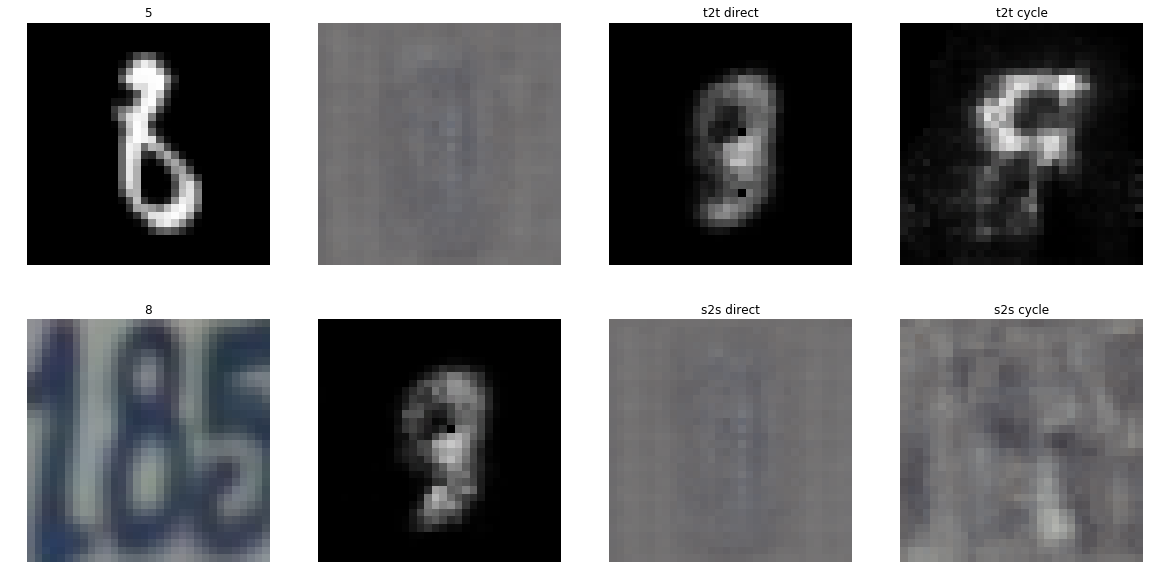

In [62]:
index = 42
plot_images(index, X_s2s, X_t2t, X_s2t, X_t2s, X_cycle_s2s, X_cycle_t2t, Y_source_predict, Y_target_predict)

### Learning curves

In [68]:
def smooth(x_list):
    res = [np.sum([x_list[k+j] for j in range(-k, k+1)])]
    for i in range(k+1, len(x_list)-k):
        res.append(res[-1] - x_list[i-k-1] + x_list[i+k])
    return np.array(res) / (2 * k)

#### Total loss

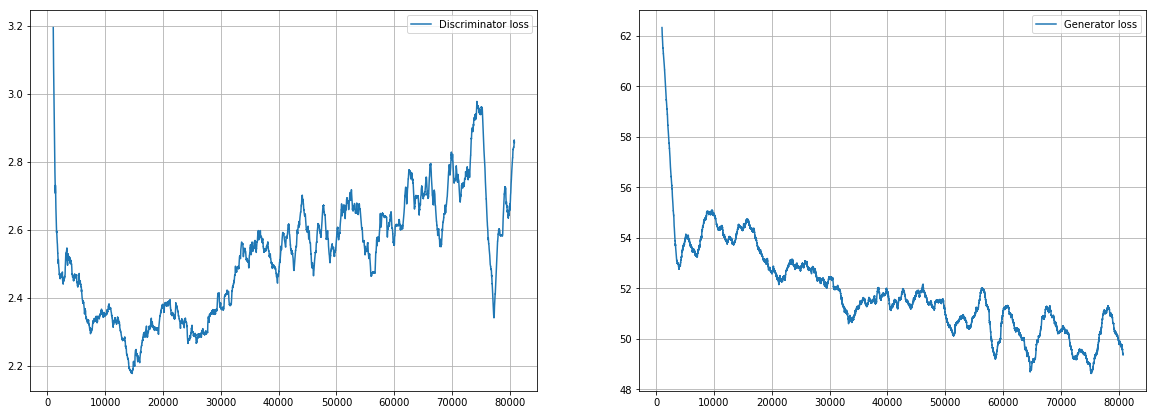

In [70]:
k = 1000
start = 0

plt.rcParams['figure.figsize'] = (20, 7)

plt.subplot(1,2,1)
plt.plot(iter_list[k+start:-k], smooth(D_loss_list[start:]), label="Discriminator loss")
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(iter_list[k+start:-k], smooth(G_loss_list[start:]), label="Generator loss")
plt.legend()
plt.grid()

if save_images:
    plt.savefig("experiments/{0:02d}/curves/total-loss-smooth-{1:04d}.png".format(id_experiment, k))

#### GAN losses

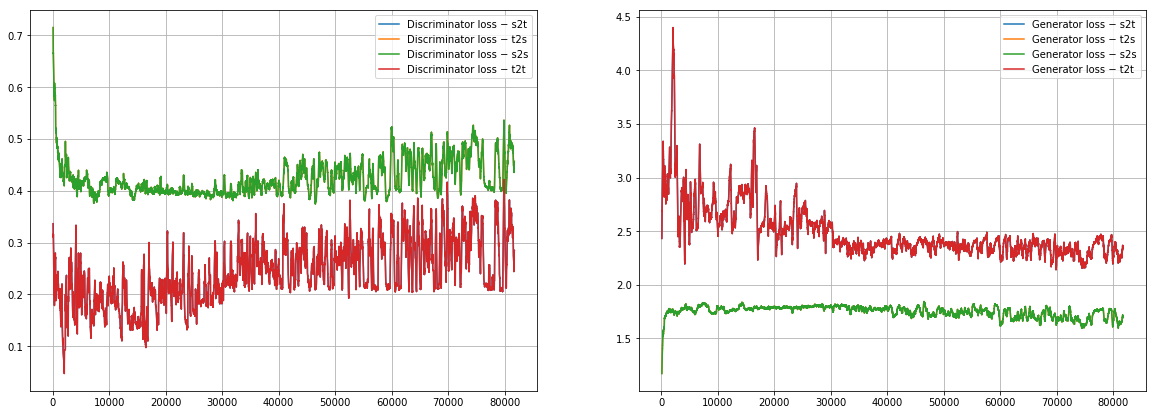

In [71]:
k = 100
start = 0

plt.rcParams['figure.figsize'] = (20, 7)

plt.subplot(1,2,1)
plt.plot(iter_list[k+start:-k], smooth(D_s2t_loss_list[start:]), label="Discriminator loss − s2t")
plt.plot(iter_list[k+start:-k], smooth(D_t2s_loss_list[start:]), label="Discriminator loss − t2s")
plt.plot(iter_list[k+start:-k], smooth(D_s2s_loss_list[start:]), label="Discriminator loss − s2s")
plt.plot(iter_list[k+start:-k], smooth(D_t2t_loss_list[start:]), label="Discriminator loss − t2t")
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(iter_list[k+start:-k], smooth(G_s2t_loss_list[start:]), label="Generator loss − s2t")
plt.plot(iter_list[k+start:-k], smooth(G_t2s_loss_list[start:]), label="Generator loss − t2s")
plt.plot(iter_list[k+start:-k], smooth(G_s2s_loss_list[start:]), label="Generator loss − s2s")
plt.plot(iter_list[k+start:-k], smooth(G_t2t_loss_list[start:]), label="Generator loss − t2t")
plt.legend()
plt.grid()

if save_images:
    plt.savefig("experiments/{0:02d}/curves/gan-losses-smooth-{1:04d}.png".format(id_experiment, k))

#### VAE losses

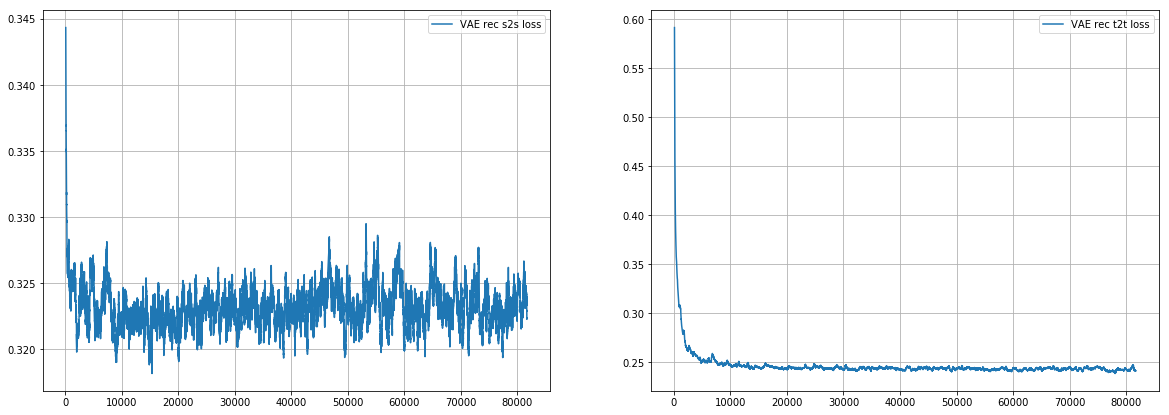

In [72]:
k = 100
start = 0

plt.subplot(1,2,1)
plt.plot(iter_list[k+start:-k], smooth(vae_rec_s2s_loss_list[start:]), label="VAE rec s2s loss")
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(iter_list[k+start:-k], smooth(vae_rec_t2t_loss_list[start:]), label="VAE rec t2t loss")
plt.legend()
plt.grid()

if save_images:
    plt.savefig("experiments/{0:02d}/curves/vae-rec-losses-smooth-{1:04d}.png".format(id_experiment, k))

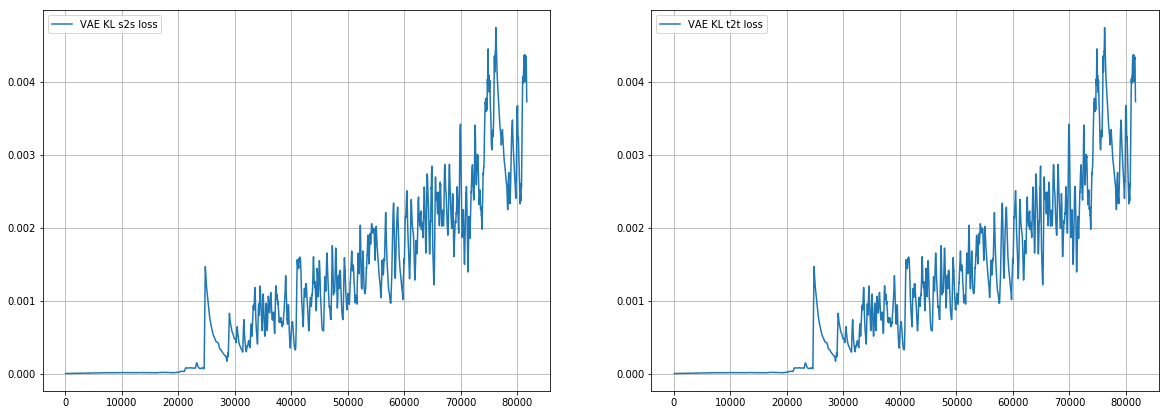

In [73]:
k = 100
start = 0

plt.subplot(1,2,1)
plt.plot(iter_list[k+start:-k], smooth(vae_kl_s2s_loss_list[start:]), label="VAE KL s2s loss")
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(iter_list[k+start:-k], smooth(vae_kl_t2t_loss_list[start:]), label="VAE KL t2t loss")
plt.legend()
plt.grid()

if save_images:
    plt.savefig("experiments/{0:02d}/curves/vae-kl-losses-smooth-{1:04d}.png".format(id_experiment, k))

#### Cycle loss

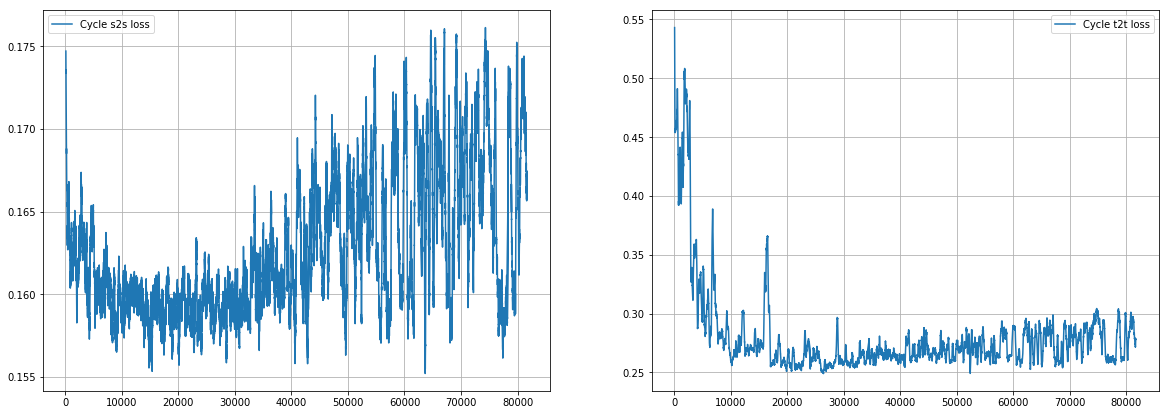

In [74]:
k = 100
start = 0

plt.subplot(1,2,1)
plt.plot(iter_list[k+start:-k], smooth(cycle_s2s_loss_list[start:]), label="Cycle s2s loss")
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(iter_list[k+start:-k], smooth(cycle_t2t_loss_list[start:]), label="Cycle t2t loss")
plt.legend()
plt.grid()

if save_images:
    plt.savefig("experiments/{0:02d}/curves/cycle-losses-smooth-{1:04d}.png".format(id_experiment, k))

#### Classification loss

In [75]:
# classif_vae_loss_list[73601:] = list(np.array(classif_vae_loss_list[73601:])*10.)

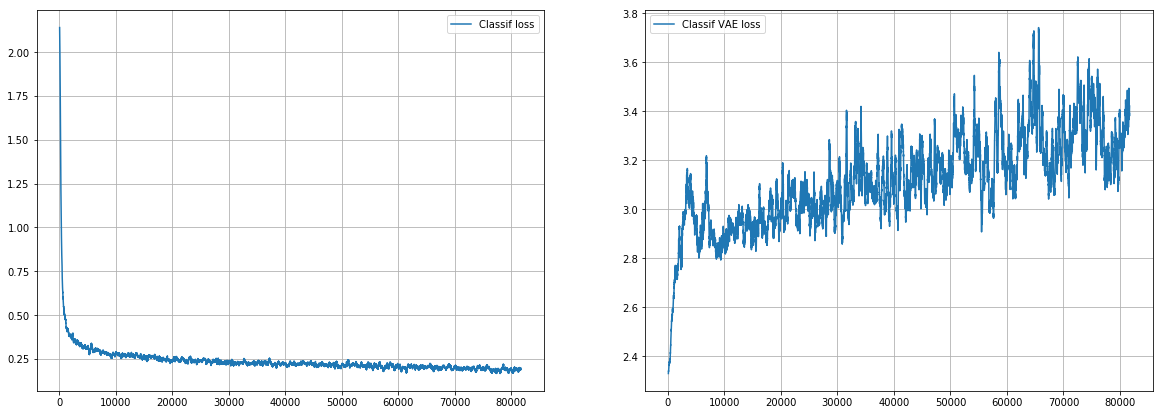

In [76]:
k = 100
start = 0
start_vae = 0

plt.subplot(1,2,1)
plt.plot(iter_list[k+start:-k], smooth(classif_source_loss_list[start:]), label="Classif loss")
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(iter_list[k+start_vae:-k], smooth(classif_vae_loss_list[start_vae:]), label="Classif VAE loss")
plt.legend()
plt.grid()

if save_images:
    plt.savefig("experiments/{0:02d}/curves/classif-losses-smooth-{1:04d}.png".format(id_experiment, k))

#### L1 loss

In [77]:
# l1_t2s_loss_list[:73601] = list(np.array(l1_t2s_loss_list[:73601])*10.)

In [78]:
# k = 10
# start = 0

# plt.subplot(1,2,1)
# plt.plot(iter_list[k+start:-k], smooth(l1_s2t_loss_list[start:]), label="L1 s2t loss")
# plt.legend()

# plt.subplot(1,2,2)
# plt.plot(iter_list[k+start:-k], smooth(l1_t2s_loss_list[start:]), label="L1 t2s loss")
# plt.legend()

#### Entropy loss

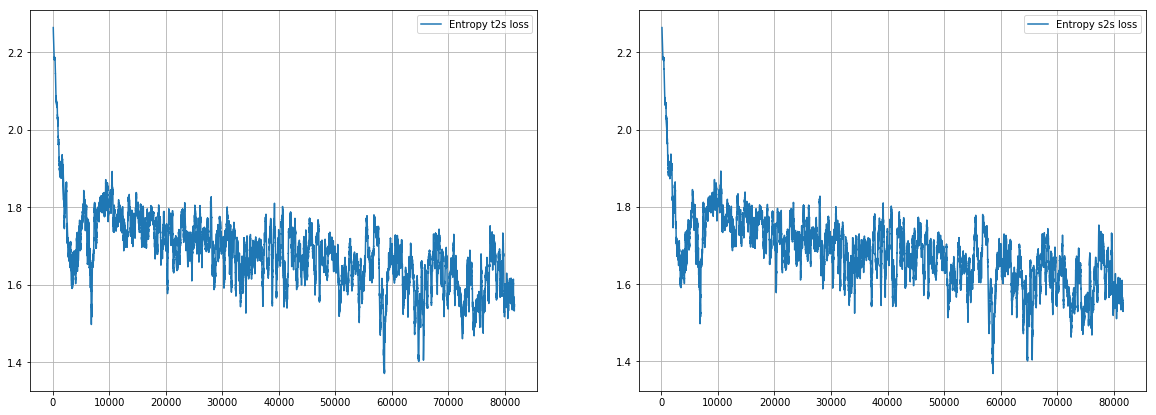

In [79]:
k = 100
start = 0

plt.subplot(1,2,1)
plt.plot(iter_list[k+start:-k], smooth(entropy_t2s_loss_list[start:]), label="Entropy t2s loss")
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(iter_list[k+start:-k], smooth(entropy_s2s_loss_list[start:]), label="Entropy s2s loss")
plt.legend()
plt.grid()

if save_images:
    plt.savefig("experiments/{0:02d}/curves/entropy-losses-smooth-{1:04d}.png".format(id_experiment, k))

#### Discriminator Regularization loss

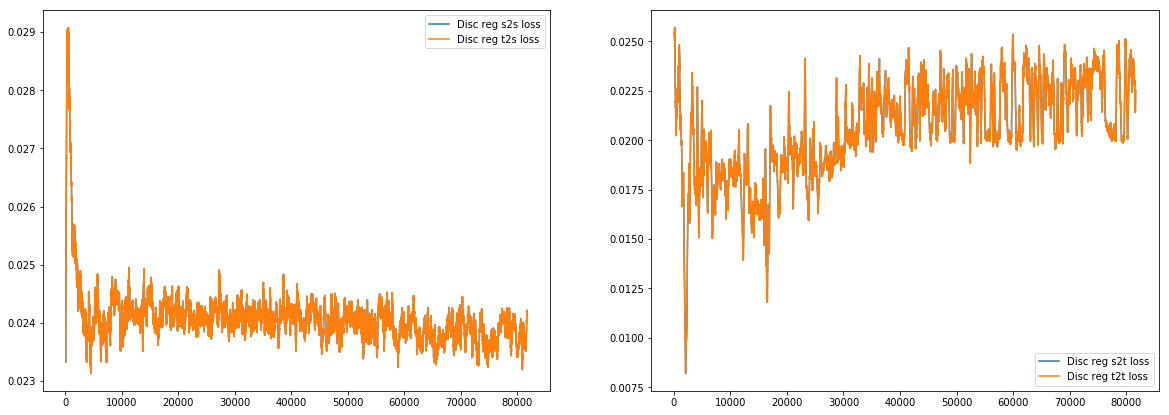

In [80]:
k = 100
start = 0

plt.subplot(1,2,1)
plt.plot(iter_list[k+start:-k], smooth(discreg_s2s_loss_list[start:]), label="Disc reg s2s loss")
plt.plot(iter_list[k+start:-k], smooth(discreg_t2s_loss_list[start:]), label="Disc reg t2s loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(iter_list[k+start:-k], smooth(discreg_s2t_loss_list[start:]), label="Disc reg s2t loss")
plt.plot(iter_list[k+start:-k], smooth(discreg_t2t_loss_list[start:]), label="Disc reg t2t loss")
plt.legend()

if save_images:
    plt.savefig("experiments/{0:02d}/curves/discreg-losses-smooth-{1:04d}.png".format(id_experiment, k))

#### Validation accuracy

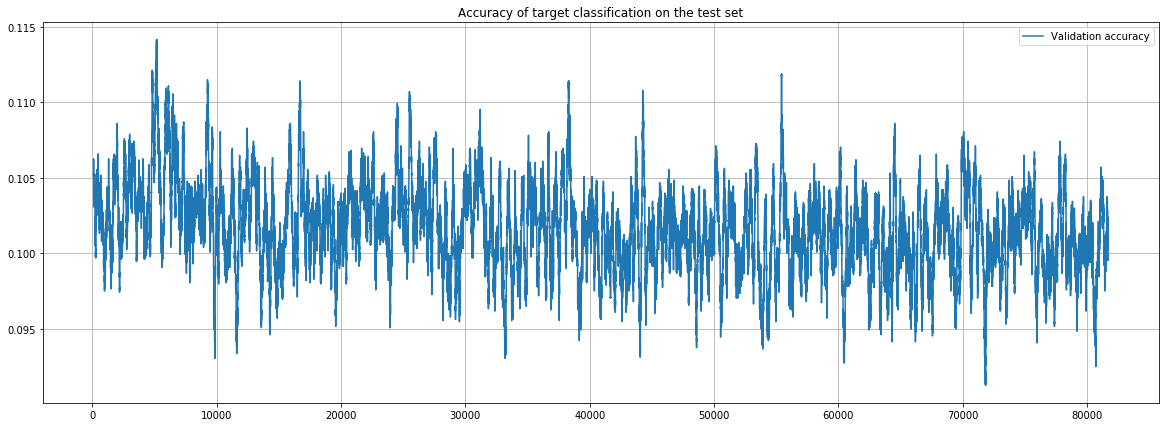

In [81]:
k = 100
start = 0

plt.title("Accuracy of target classification on the test set")
plt.plot(iter_list[k+start:-k], smooth(accuracy_list[start:]), label="Validation accuracy")
plt.grid()
plt.legend()

if save_images:
    plt.savefig("experiments/{0:02d}/curves/validation-accuracy-smooth-{1:04d}.png".format(id_experiment, k))

## Test the results

### Accuracy

In [ ]:
nbr_batches = len(X_target_test) // batch_size
# nbr_batches = 40
Y_target_predict = []

for start in tqdm(range(0, batch_size*nbr_batches, batch_size)):
    target_predict = tf.nn.softmax(DG_t2s_classif_mean)
    test_samples = X_target_test[start:batch_size+start]
    Y_target_predict = np.concatenate([Y_target_predict, 
                                       np.argmax(sess.run(target_predict, feed_dict={ipt_target: test_samples}), 
                                                 axis=1)])

In [ ]:
acc = accuracy_score(Y_target_test[:batch_size*nbr_batches], Y_target_predict)
acc

In [ ]:
np.savetxt("experiments/{0:02d}/accuracy/accuracy.txt".format(id_experiment, batch_size*nbr_batches),
           np.array([["Accuracy"],[acc]]), delimiter=":", fmt="%s")

### Classification

#### On the training set

In [ ]:
start = 0
nbr_samples = 3000

Y_source_predict = np.argmax(sess.run(tf.nn.softmax(discriminator(ipt_source, "source")[2]), 
                                      feed_dict={ipt_source: X_source[start:nbr_samples+start]}), axis=1)

In [ ]:
accuracy_score(np.argmax(Y_source, axis=1)[start:nbr_samples+start], Y_source_predict)

#### On the test set

In [ ]:
start = 0
nbr_samples = 3500
Y_source_predict = np.argmax(sess.run(tf.nn.softmax(discriminator(ipt_source, "source")[2]), 
                                      feed_dict={ipt_source: X_source_test[start:nbr_samples+start]}), axis=1)

In [ ]:
accuracy_score(Y_source_test[start:nbr_samples+start], Y_source_predict)

## Debug

### Gradients

In [ ]:
print("Gradient of D with respect to", ipt_source)
gradient = sess.run(tf.gradients(discriminator(ipt_source, "source")[1], ipt_source), 
                    feed_dict={ipt_source: sample_source})
print("Min:", np.array(np.abs(gradient)).min())
print("Max:", np.array(gradient).max())
print("Avg:", np.array(np.abs(gradient)).mean())

In [ ]:
print("Gradient of D with respect to", ipt_target)
gradient = sess.run(tf.gradients(discriminator(ipt_target, "target")[1], ipt_target), 
                    feed_dict={ipt_target: sample_target})

print("Min:", np.array(gradient).min())
print("Max:", np.array(gradient).max())
print("Avg:", np.array(np.abs(gradient)).mean())

In [ ]:
ind = 1
print("Gradient with respect to", G_s2t_vars[ind])
gradient = sess.run(tf.gradients(G_s2t_loss, G_s2t_vars[ind]), feed_dict={ipt_source: sample_source, 
                                                                          ipt_target: sample_target})
print("Min:", np.array(gradient).min())
print("Max:", np.array(gradient).max())
print("Avg:", np.array(gradient).mean())

In [ ]:
ind = 2
print("Gradient with respect to", G_t2s_vars[ind])
gradient = sess.run(tf.gradients(G_t2s_loss, G_t2s_vars[ind]), feed_dict={ipt_source: sample_source, 
                                                                          ipt_target: sample_target})
print("Min:", np.array(gradient).min())
print("Max:", np.array(gradient).max())
print("Avg:", np.array(gradient).mean())

### T-SNE

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
N = 500
idx_sample_target = np.random.choice(len(X_target_test), N)
sample_target = X_target_test[idx_sample_target]
sample_target_labels = Y_target_test[idx_sample_target]
embed_target = sess.run(DG_t2s_embed_mean, feed_dict={ipt_target: sample_target}).reshape((N,2048))

In [ ]:
tsne_target = TSNE(n_components=2).fit_transform(embed_target)

In [ ]:
for i in range(10):
    plt.scatter(tsne_target[:,0][sample_target_labels == i], tsne_target[:,1][sample_target_labels == i], label=str(i))
plt.legend()